# Nursing Home Objects Image Classification via Neural Network

This notebook goes through end to end data retrieval from s3, data preprocessing, model building, and model evaluation.

In [31]:
import numpy as np
import os
import tensorflow as tf
import boto3
import io
from PIL import Image
import matplotlib.pyplot as plt

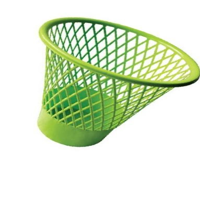

In [32]:
# Initialize S3 client
s3 = boto3.client('s3')

# Specify your bucket and prefix (directory)
bucket_name = 'bigdata-project-data'
prefix = 'uva-projects/nursing_home_data/basket_bin/'

# Use list_objects_v2 to list objects in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Iterate over the objects and open the first image
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.lower().endswith('.jpg'):  # Assuming JPEG images
        # Download the image
        image_object = s3.get_object(Bucket=bucket_name, Key=key)
        # Open the image using PIL
        image = Image.open(io.BytesIO(image_object['Body'].read()))
        # Resize the image to a smaller size
        # Change (width, height) to your desired size
        smaller_image = image.resize((200, 200))
        # Display the resized image
        smaller_image.show()
        # Break out of the loop after opening the first image
        break

## Load Data to Directory from S3 bucket

- load from s3 bucket 'bigdata-project-data' to local directory and format into tensorflow keras format.
- split data into 80% training, 10% validation, and 10% test.
- EDA on images and labels as well as data distribution of classes.



run this in terminal (preferred) or notebook

In [ ]:
#!aws s3 sync s3://bigdata-project-data/uva-projects/nursing_home_data /home/sagemaker-user/bigdata-project/data

In [40]:
# Define your local data directory (where you want to download the data)
local_data_dir = '/home/sagemaker-user/bigdata-project/data'

# Use tf.keras.utils.image_dataset_from_directory with the local directory
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    local_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 37500 files belonging to 25 classes.
Using 30000 files for training.


2024-04-21 20:15:04.964708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


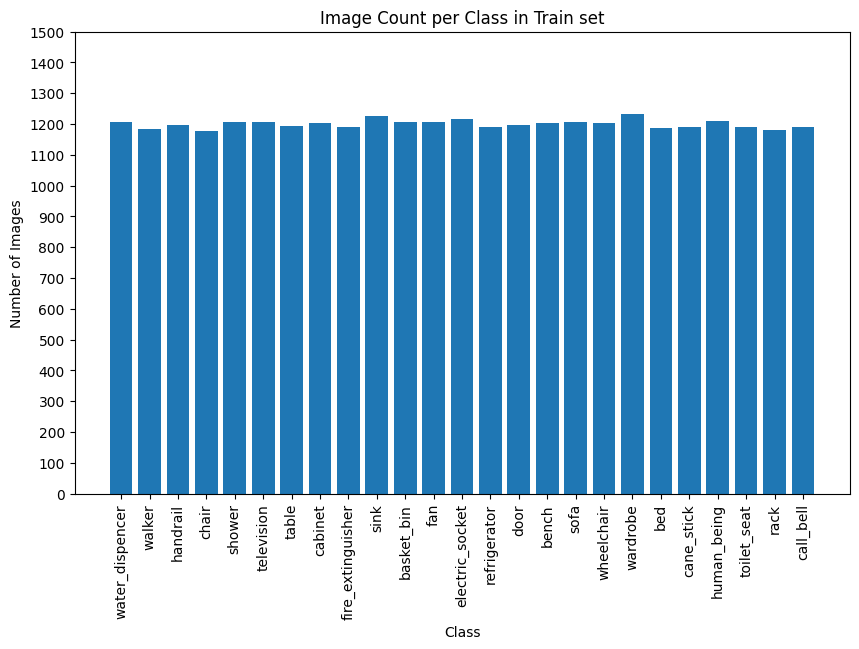

In [41]:
# Get the class names from the dataset
class_names = train_ds.class_names

# Count the number of images in each class
class_counts = {}
for image_batch, label_batch in train_ds:
    for label in label_batch:
        class_name = class_names[label.numpy()]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Create a bar chart of the class counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class in Train set')
plt.xticks(rotation=90)

# Set the y-axis intervals to multiples of 100
max_count = max(class_counts.values())+200
interval = 100
yticks = list(range(0, max_count + interval, interval))
plt.yticks(yticks)

plt.show()

In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  local_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 37500 files belonging to 25 classes.
Using 7500 files for validation.


2024-04-21 20:15:13.422585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


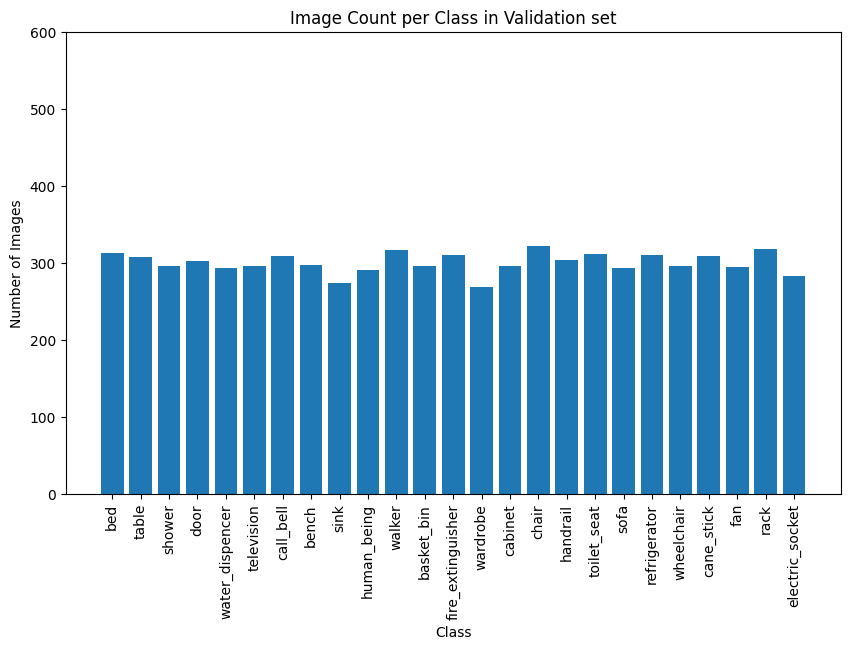

In [43]:
# Get the class names from the dataset
class_names = val_ds.class_names

# Count the number of images in each class
class_counts = {}
for image_batch, label_batch in val_ds:
    for label in label_batch:
        class_name = class_names[label.numpy()]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Create a bar chart of the class counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class in Validation set')
plt.xticks(rotation=90)

# Set the y-axis intervals to multiples of 100
max_count = max(class_counts.values())+200
interval = 100
yticks = list(range(0, max_count + interval, interval))
plt.yticks(yticks)

plt.show()

In [44]:
len(train_ds.class_names)

25

2024-04-21 20:15:14.020873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


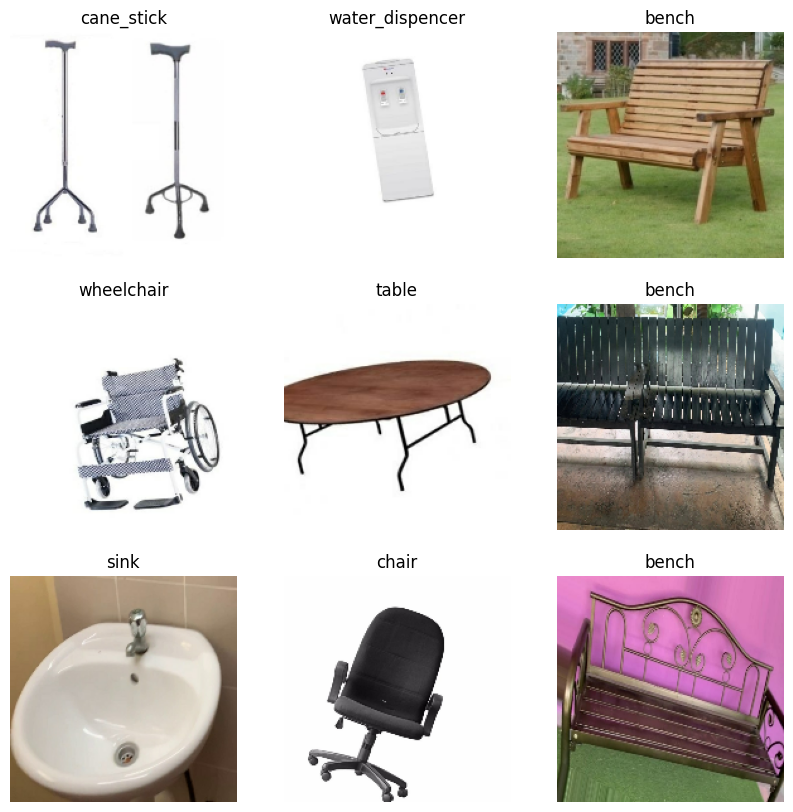

In [45]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [46]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [47]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 118
Number of test batches: 117


Buffer prefetching to optimize data retrieval performance.

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Data augmentation to increase data diversity in training data.

In [49]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2024-04-21 20:15:15.169730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


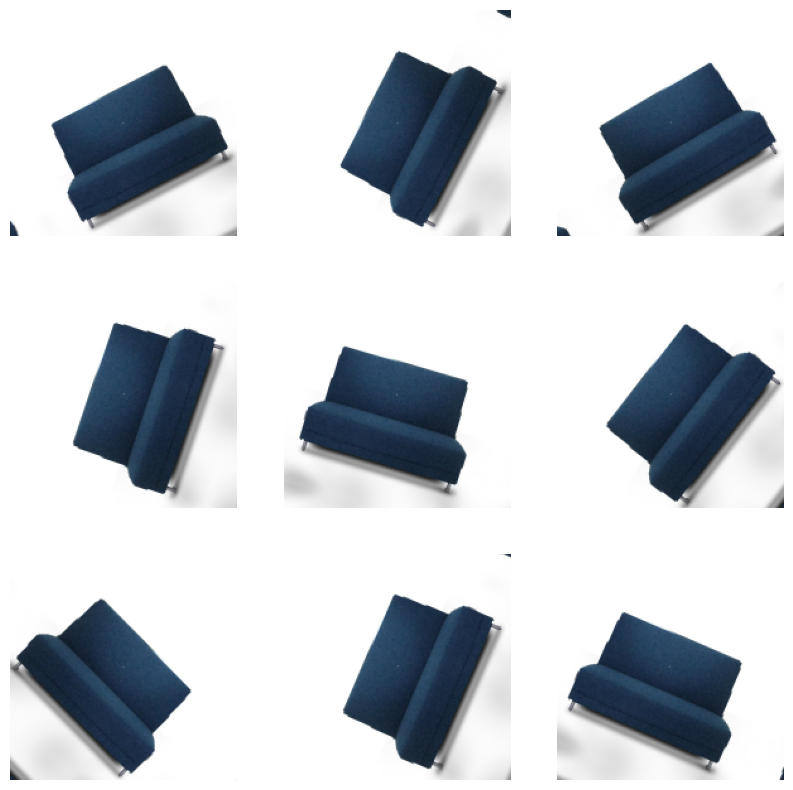

In [50]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Building Model Pipeline using ResNet50 pre-trained model. 

In [51]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [52]:
# Define the input shape and image size
IMG_SIZE = (180, 180)
IMG_SHAPE = IMG_SIZE + (3,)

# Create the base model from the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [53]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


Freeze pretrained ResNet50 model layers.

In [54]:
base_model.trainable = False

In [55]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [56]:
prediction_layer = tf.keras.layers.Dense(25)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 25)


In [57]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Model Architecture in table below.

In [58]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 6, 6,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25)        │     51,225 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,638,937 (90.18 MB)

 Trainable params: 51,225 (200.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Model Training Parameters

In [59]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(val_ds)

118/118 ━━━━━━━━━━━━━━━━━━━━ 77s 600ms/step - accuracy: 0.0246 - loss: 4.1306


In [61]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.13
initial accuracy: 0.03


In [62]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 673s 711ms/step - accuracy: 0.7350 - loss: 0.9160 - val_accuracy: 0.9337 - val_loss: 0.2178
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 661s 704ms/step - accuracy: 0.9155 - loss: 0.2724 - val_accuracy: 0.9457 - val_loss: 0.1949
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 666s 710ms/step - accuracy: 0.9260 - loss: 0.2346 - val_accuracy: 0.9414 - val_loss: 0.1960
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 663s 706ms/step - accuracy: 0.9349 - loss: 0.2023 - val_accuracy: 0.9531 - val_loss: 0.1758
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 664s 707ms/step - accuracy: 0.9367 - loss: 0.1917 - val_accuracy: 0.9547 - val_loss: 0.1653


### ResNet50 trained with Nursing Home Images Evaluation

Text(0.5, 1.0, 'Training and Validation Loss')

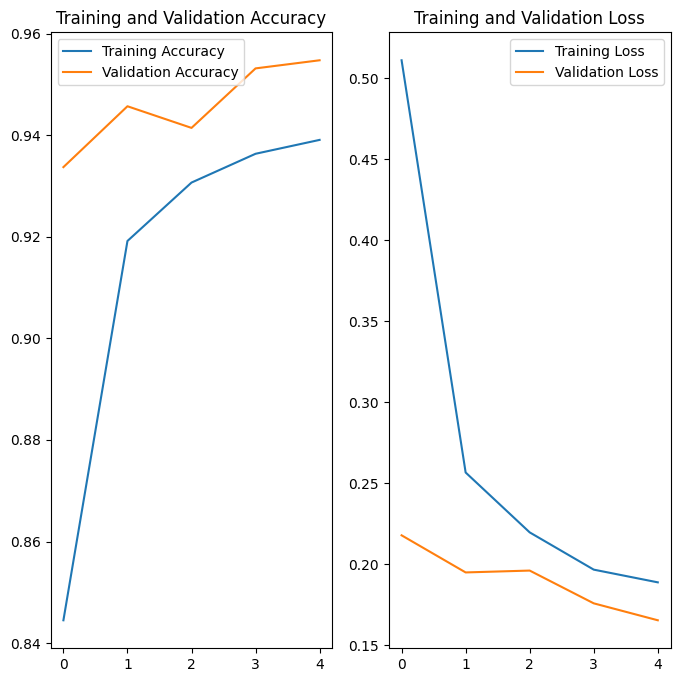

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [64]:
loss, accuracy = model.evaluate(test_ds)
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)

117/117 ━━━━━━━━━━━━━━━━━━━━ 71s 604ms/step - accuracy: 0.9568 - loss: 0.1597
Test Accuracy: 0.9556623697280884
Test Loss: 0.15010258555412292


Predictions:
 [13 23 15 12 11 20 17 10 22 12  0  1 19  0  0 21 23 21 15  3  4 21 15  8
 22 13  4 12 15  8  1 18]
Labels:
 [13 23 15 12 11 20 17 10 22 12  0  1 19  0  0 21 23 21 15  3  4 21 15  8
 22 13  4 12  5  8  1 18]


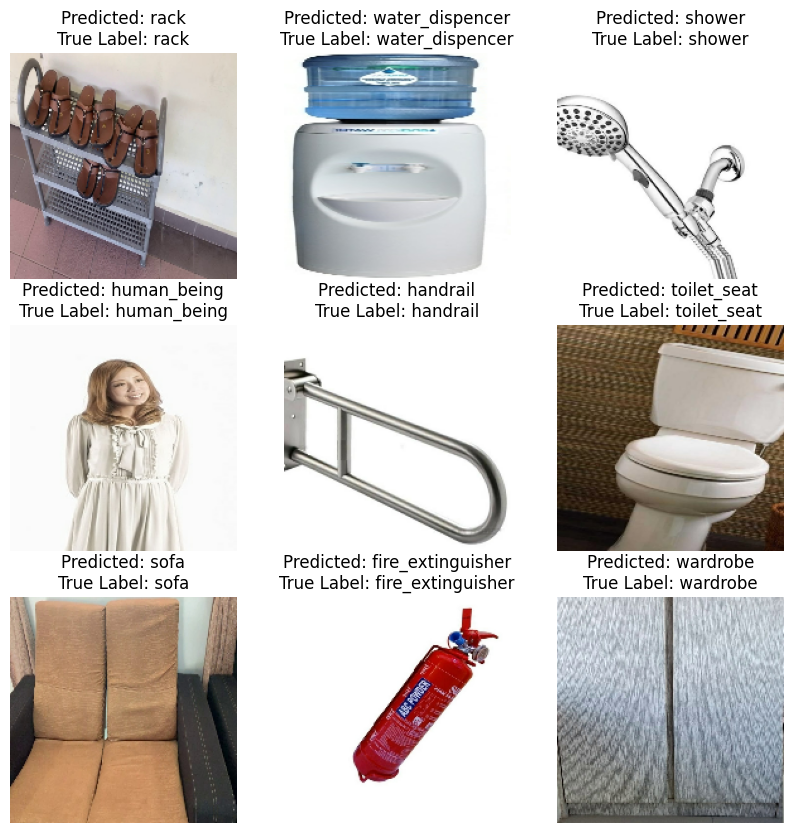

In [65]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)

# Apply softmax to convert logits to probabilities
predictions = tf.nn.softmax(predictions, axis=-1)

# Get the predicted class indices
predicted_class_indices = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class_indices.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    predicted_class_index = predicted_class_indices[i].numpy()
    true_label = label_batch[i]
    plt.title(f"Predicted: {class_names[predicted_class_index]}\nTrue Label: {class_names[true_label]}")
    plt.axis("off")